## Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

In [3]:
PATH = "/home/nbuser/courses/fastai/courses/ml1/data/bulldozers/"

In [4]:
!ls {PATH}

'ls' is not recognized as an internal or external command,
operable program or batch file.


## The Data

In [3]:
# data = pd.read_csv(f'{PATH}Train.csv', low_memory=False, parse_dates=['saledate'])
data = pd.read_csv('Train.csv', low_memory=False, parse_dates=['saledate'])

### Looking at the data

In [4]:
data.shape

(401125, 53)

In [5]:
data.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [6]:
# Context manager to temporarily set options in the with statement context
def display_all(df):
    with pd.option_context('display.max_rows', 1000, 'display.max_columns', 1000):
        display(df)

In [7]:
display_all(data.head(2))

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional


In [8]:
# display_all(data.describe(include='all').T).head()

In [9]:
# Transform SalePrice to log to comply with Kaggle evaluation
data['SalePrice'] = np.log(data['SalePrice'] )

In [10]:
data.SalePrice.head()

0    11.097410
1    10.950807
2     9.210340
3    10.558414
4     9.305651
Name: SalePrice, dtype: float64

### Initial Processing

In [11]:
# Extracting date attributes from saledate and dropping original column
def datetransform(df, fldname, drop=True):
    fld = df[fldname]
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear','Is_month_end', 'Is_month_start', 'Is_quarter_end', \
              'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        df['Sales_'+n] = getattr(fld.dt, n.lower())
    df["Sales_"+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop:
        df = df.drop(fldname, axis=1, inplace=True)

In [12]:
datetransform(data, 'saledate')

In [13]:
data.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'Sales_Year', 'Sales_Month',
       'Sales_Week', 'Sales_Day', 'Sales_Dayofweek', 'Sales_

In [14]:
def catconv(df):
    for n in df:
        if df[n].dtypes == object:
            df[n] = df[n].astype('category')

In [15]:
# Convert object to categorical variable
catconv(data)

In [16]:
data.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [17]:
# This is how much of a varaible is null 
data.isnull().sum().sort_index()/len(data)*100

Backhoe_Mounting            80.387161
Blade_Extension             93.712932
Blade_Type                  80.097725
Blade_Width                 93.712932
Coupler                     46.662013
Coupler_System              89.165971
Differential_Type           82.695918
Drive_System                73.982923
Enclosure                    0.081022
Enclosure_Type              93.712932
Engine_Horsepower           93.712932
Forks                       52.115425
Grouser_Tracks              89.189903
Grouser_Type                75.281271
Hydraulics                  20.082269
Hydraulics_Flow             89.189903
MachineHoursCurrentMeter    64.408850
MachineID                    0.000000
ModelID                      0.000000
Pad_Type                    80.271985
Pattern_Changer             75.265067
ProductGroup                 0.000000
ProductGroupDesc             0.000000
ProductSize                 52.545964
Pushblock                   93.712932
Ride_Control                62.952696
Ripper      

In [18]:
os.makedirs('tmp', exist_ok=True)
# data.to_feather('tmp/bulldozers-raw')

### Preprocessing

In [19]:
# df_raw = pd.read_feather('tmp/bulldozers-raw')
df_raw = data

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [20]:
from pandas.api.types import is_string_dtype, is_numeric_dtype

def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+"_na"] = pd.isnull(col)
            filler = col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

In [21]:
def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and (max_n_cat is None or col.nunique() > max_n_cat):
        df[name] = col.cat.codes+1

In [22]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler

def scale_vars(df, mapper):
    if mapper is None:
        map_f = [([n],StandardScaler()) for n in df if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

In [23]:
def get_sample(df, n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [24]:
def proc_df(df, y_fld, skip_flds=None, do_scale=False, na_dict=None, max_n_cat=None, subset=None, mapper=None):
   
    if not skip_flds:
        skip_flds = []
    if subset:
        df = get_sample(df, subset)
    df = df.copy()
    y = df[y_fld].values
    df.drop(skip_flds+[y_fld], axis =1, inplace=True)
    
    if na_dict is None:
        na_dict = {}
    for n,c in df.items():
        na_dict = fix_missing(df, c, n, na_dict)
    if do_scale:
        mapper = scale_vars(df, mapper)
    for n,c in df.items():
        numericalize(df, c, n, max_n_cat)
    res = [pd.get_dummies(df, dummy_na = True), y, na_dict]
    if do_scale:
        res = res + [mapper]
    return res
        

In [25]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [27]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df, y)

0.982986426360526

R-squared of 0.98? Are we overfitting the data, the best way is to seperate out data into training and validation

In [28]:
len(df)

401125

In [26]:
def split_data(df, n):
    return df[0:n].copy(), df[n:].copy()

In [27]:
n_valid = 12000 # Same as Kaggle's test set
n_trn = len(df)-n_valid

raw_train, raw_valid = split_data(df_raw, n_trn) #Splitting the raw data
X_train, X_valid = split_data(df, n_trn)
y_train, y_valid = split_data(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape, 

((389125, 66), (389125,), (12000, 66))

# Random Forest

## Base Model

In [36]:
import math
def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())

In [37]:
def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
    m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'):
        res.append(m.oob_score_)
    print(res)

In [33]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 18.3 s
[0.09049560509437828, 0.24837200812041238, 0.9828844916529803, 0.8898325565493075]


## Speeding things up

In [34]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset= 30000, na_dict=nas)

X_train, _ = split_data(df_trn, 20000) # Use _ cuz I dont want to chamge my validation set, rather I want to throw it away
y_train, _ = split_data(y_trn, 20000)

In [35]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 760 ms
[0.11195907724899545, 0.3480438053022919, 0.9726500262921128, 0.7836704780149717]


## Single tree

In [6]:
from sklearn.tree import export_graphviz

def draw_tree(t, df,  size=10, ratio=0.6, precision=0):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s)))

In [54]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.5371269683343529, 0.5674541015387262, 0.3970396664995464, 0.424944908737197]


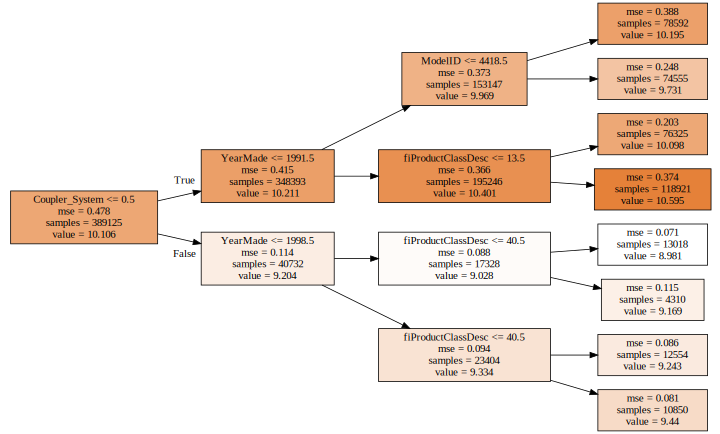

In [55]:
draw_tree(m.estimators_[0], df_trn, precision=3)

In [25]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[7.536443801682121e-17, 0.4797389301108064, 1.0, 0.5889847854047335]


## Bagging

### Intro to bagging

To learn about bagging in random forests, let's start with our basic model again.

In [26]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.11145979473450096, 0.3761791704270528, 0.9728049004634968, 0.7472812511888947]


We'll grab the predictions for each individual tree, and look at one example.

In [27]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([ 8.9872 , 10.12663,  9.3501 ,  9.6486 ,  9.25913,  9.10498,  9.25913,  8.9872 ,  9.90349,  9.21034]),
 9.383679121555486,
 9.104979856318357)

In [28]:
preds.shape

(10, 12000)

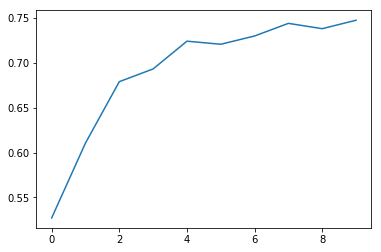

In [140]:
plt.plot([r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

The number here at the 10th tree shall match the last score in the print_score:
[0.11145979473450096, 0.3761791704270528, 0.9728049004634968, 0.7472812511888947]

In [141]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.10265366614849009, 0.37917387512054745, 0.9769323632747796, 0.7432415247018948]


In [142]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09392961472226918, 0.3699937827528779, 0.9806865768069059, 0.7555236647529878]


### Out-of-bag (OOB) score

In [145]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.09647135727965261, 0.36401582773787355, 0.9796271891793586, 0.7633598079346455, 0.8529476095700255]


## Reducing over-fitting

In [17]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', na_dict=nas)
X_train, X_valid = split_data(df_trn, n_trn)
y_train, y_valid = split_data(y_trn, n_trn)

In [27]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11925551304473253, 0.22949470443593706, 0.9702770605813713, 0.9059425259598639, 0.9116323323225264]


# Random Forest Model interpretation

In [28]:
# df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [29]:
n_valid = 12000 # Same as Kaggle's test set
n_trn = len(df_trn)-n_valid

raw_train, raw_valid = split_data(df_raw, n_trn) #Splitting the raw data
X_train, X_valid = split_data(df_trn, n_trn)
y_train, y_valid = split_data(y_trn, n_trn)

Profiling to check which lines takes most time to get it to run faster

# Confidence based on tree variance

In [30]:
from sklearn.ensemble import forest
def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

In [31]:
def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

In [32]:
# While bootstrapping, change Random Forest Sample to give every tree a random sample of max 50,000
set_rf_samples(50000)

We do the above because we dont want massivaly accurante RF, but which indicates the nature of relationship, but make it high enough and run in seconds

In [50]:
# reset_rf_samples()

In [38]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.20592374935644875, 0.2502880185798036, 0.9113767443454424, 0.8881262761359596]


In [39]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])# Concat 12,000 predictions for every tree each in a list of arrays 

In [40]:
preds[:,0] # This extract all 12000 predictions from the first tree

array([ 9.57921412,  8.9759412 ,  9.37391536,  9.10420706,  9.08396479,
       10.15316396,  9.19294654,  9.38844917,  9.1990263 ,  9.10199442,
        9.24211043,  9.46573848,  9.00707935,  9.21384274,  9.270193  ,
        9.1718704 ,  9.06468845,  8.98719682,  9.15812244,  9.04110257,
        9.76616631,  9.33709183,  9.10199442,  9.73948967,  9.0678519 ,
        9.84847317,  9.57571009,  9.31783895,  8.97106219,  9.15168653,
        8.95912706,  9.11431299,  9.0087054 ,  9.18761081,  9.28737761,
        9.02389141,  9.27832728,  9.10436162,  8.99607091,  9.34582857])

In [41]:
np.mean(preds[:,0]), np.mean(y_valid)

(9.248943658035696, 10.024625319314138)

The mean of the prediction is 9.3 while the real validation set is 10 which is not bad for one tree

In [42]:
np.mean(preds), np.mean(y_valid)

(10.00707126281339, 10.024625319314138)

Much better mean for the 40 trees

Since Python runs in series, the below will help run in parallel on all cores to make it faster

In [43]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
def parallel_trees(m, fn, n_jobs=8):
    return list(ProcessPoolExecutor(n_jobs).map(fn, m.estimators_))

In [44]:
def get_preds(t):
    return t.predict(X_valid)

if __name__ == '__parallel_trees__':
    preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

(9.248943658035696, 0.26540234216946523)

For every tree we are predicting 12,000, then getting mean and standard deviation

In [45]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)

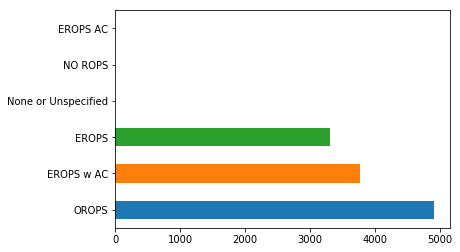

In [46]:
x.Enclosure.value_counts().plot.barh()

In [47]:
flds = ['Enclosure', 'SalePrice', 'pred_std', 'pred']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred_std,pred
0,EROPS,9.849178,0.271138,9.834368
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,0.263154,10.577401
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,0.222921,9.684943


In [48]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ

,Enclosure,SalePrice,pred_std,pred
0,EROPS,9.849178,0.271138,9.834368
2,EROPS w AC,10.623971,0.263154,10.577401
5,OROPS,9.682064,0.222921,9.684943


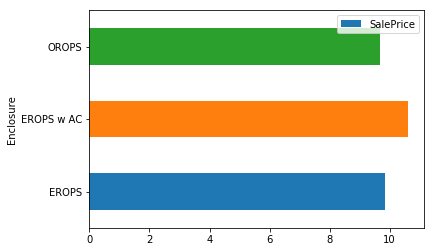

In [49]:
enc_summ.plot('Enclosure', 'SalePrice', 'barh')

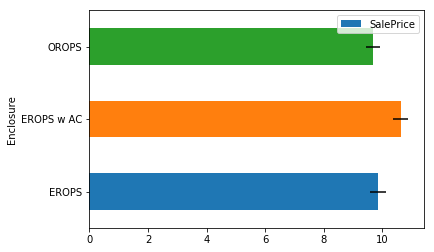

In [50]:
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xerr='pred_std')

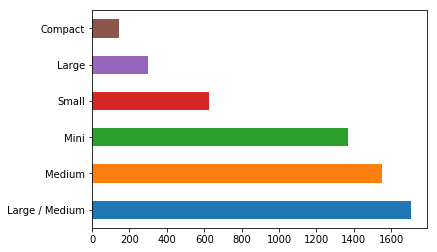

In [51]:
raw_valid.ProductSize.value_counts().plot.barh()

In [52]:
fld = ['ProductSize', 'SalePrice', 'pred_std', 'pred']
summ = x[fld].groupby(fld[0]).mean()
summ

,SalePrice,pred_std,pred
ProductSize,,,
Compact,9.735093,0.358013,9.866883
Large,10.470589,0.350216,10.393431
Large / Medium,10.691871,0.295358,10.643698
Medium,10.681511,0.280437,10.622867
Mini,9.535147,0.242606,9.551146
Small,10.324448,0.304125,10.327811


In [53]:
(summ.pred_std/summ.pred).sort_values(ascending = False)

ProductSize
Compact           0.036284
Large             0.033696
Small             0.029447
Large / Medium    0.027750
Medium            0.026399
Mini              0.025401
dtype: float64

# Feature Importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know how it's making predictions. The most important way to see this is with feature importance.

In [54]:
def rf_feat_imp(m, df):
    return pd.DataFrame({'Features': X_train.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

In [55]:
fi = rf_feat_imp(m, df_trn)
fi[:10]

,Features,imp
5,YearMade,0.174408
37,Coupler_System,0.110626
13,ProductSize,0.091247
14,fiProductClassDesc,0.090723
2,ModelID,0.055200
63,Sales_Elapsed,0.051328
38,Grouser_Tracks,0.041326
10,fiSecondaryDesc,0.041113
39,Hydraulics_Flow,0.040969
19,Enclosure,0.035139


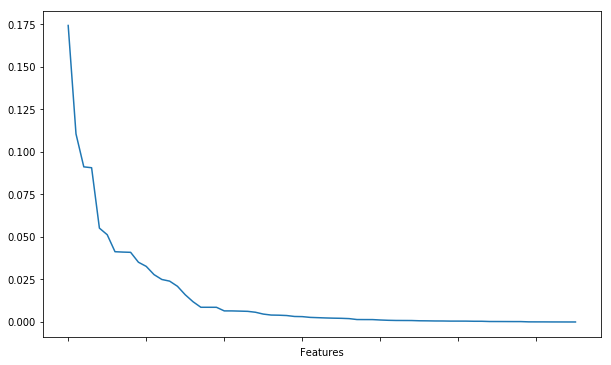

In [56]:
fi.plot('Features', "imp", figsize=(10,6), legend=False)

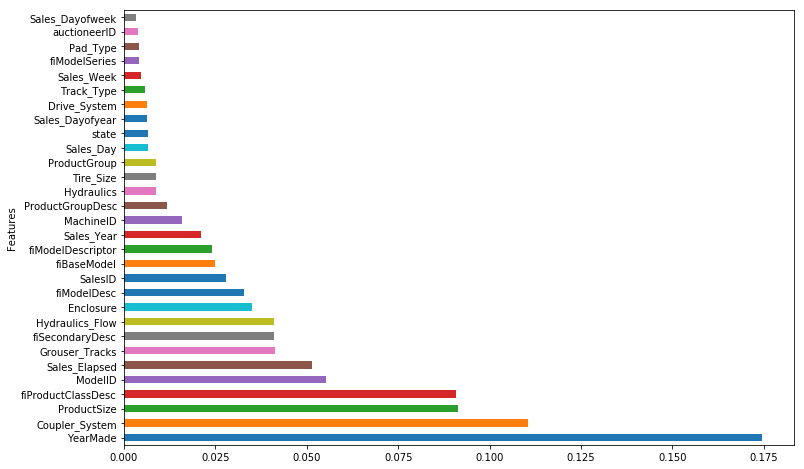

In [57]:
fi[:30].plot('Features', "imp", 'barh',figsize=(12,8), legend=False)

In [58]:
to_keep = fi[fi.imp > 0.005]
len(to_keep)

25

In [59]:
df_keep = df_trn[list(to_keep.Features)].copy()

In [60]:
X_train, X_valid = split_data(df_keep, n_trn)

In [61]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20704285885711524, 0.24556753433797585, 0.9104108661867181, 0.8923064053558971, 0.894138760852949]


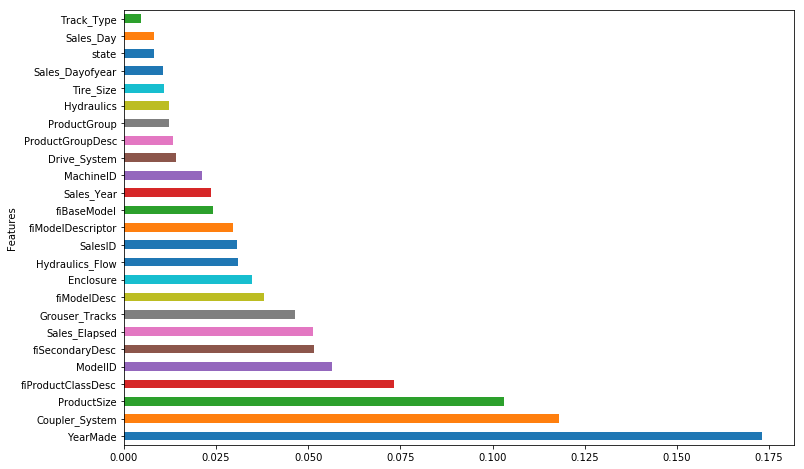

In [62]:
fi = rf_feat_imp(m, df_keep)
fi.plot('Features', "imp", 'barh',figsize=(12,8), legend=False)

## One-hot encoding

In [52]:
def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
    m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'):
        res.append(m.oob_score_)
    print(res)

In [53]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_data(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11815669116170455, 0.23495856394284872, 0.9708222722801453, 0.9014105299262688, 0.910113258361064]


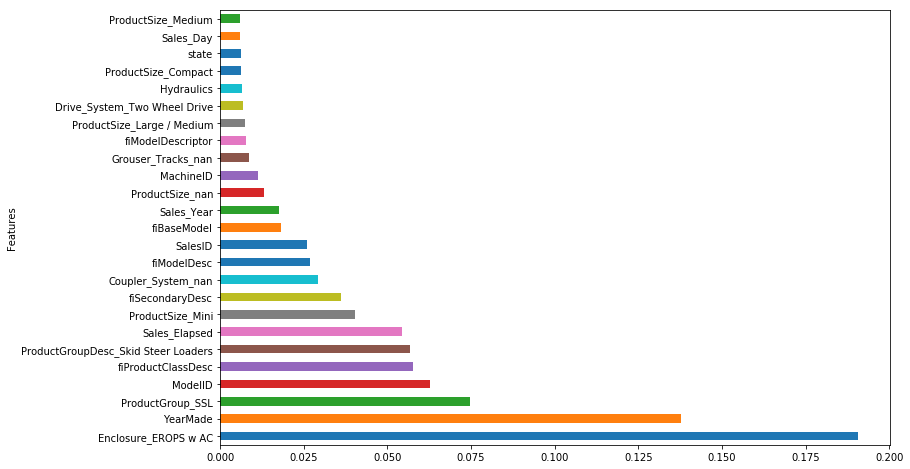

In [54]:
fi = rf_feat_imp(m, df_keep)
fi[:25].plot('Features', "imp", 'barh',figsize=(12,8), legend=False)

# Removing redundant features

In [63]:
from scipy.cluster import hierarchy as hc
import scipy

In [64]:
corr = np.round(df_keep.corr(method='spearman').values, 4) # Use rank correlation instead of correlation coefficient
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')

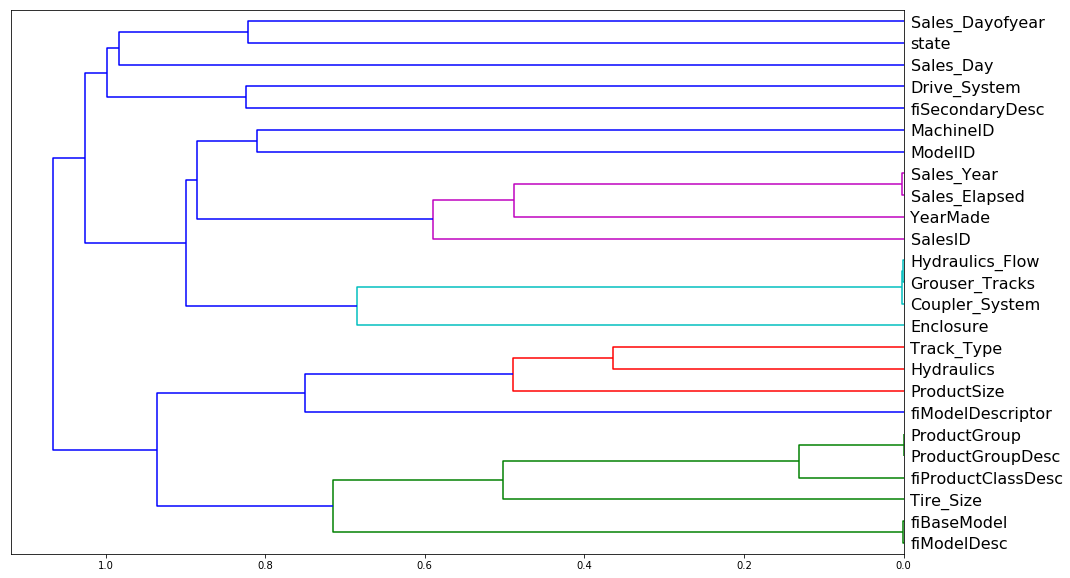

In [65]:
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [67]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_data(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [68]:
get_oob(df_keep)

0.8933580589908807

In [69]:
for i in ('Sales_Year', 'Sales_Elapsed', 'Hydraulics_Flow', 'Grouser_Tracks', 'Coupler_System', 'fiBaseModel', 'fiModelDesc', 'ProductGroup', 'ProductGroupDesc'):
    print(i, get_oob(df_keep.drop(i, axis=1)))

Sales_Year 0.8926492643983207
Sales_Elapsed 0.8909853200726822
Hydraulics_Flow 0.8939805608592456
Grouser_Tracks 0.8934556275261417
Coupler_System 0.8933981994056244
fiBaseModel 0.8923949521573618
fiModelDesc 0.8925425077025282
ProductGroup 0.893084697393558
ProductGroupDesc 0.893563985163276


We can try one from each group for removal

In [70]:
get_oob(df_keep.drop(['Sales_Year', 'fiBaseModel', 'Grouser_Tracks','ProductGroupDesc'], axis=1))

0.8919445964513604

In [71]:
df_keep.drop(['Sales_Year', 'fiBaseModel', 'Grouser_Tracks','ProductGroupDesc'], axis=1, inplace=True)
X_train, X_valid = split_data(df_keep, n_trn)

No difference in OOB, so dropping the 3 features didnt improve the error but the simpler the better

In [72]:
reset_rf_samples()

In [73]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1257810894112554, 0.2267694803435047, 0.9669352281863233, 0.908163106722476, 0.9087024483340511]


# Partial dependence

In [74]:
from pdpbox import pdp
from plotnine import *

In [75]:
set_rf_samples(50000)

This is easier if we used 1-hot encoding

In [135]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_data(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

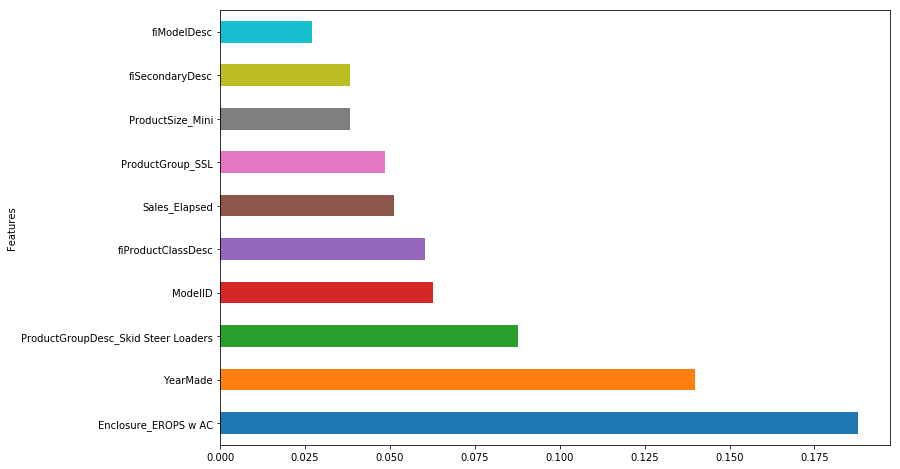

In [136]:
fi = rf_feat_imp(m, df_trn2)
fi[:10].plot('Features', 'imp', 'barh',figsize=(12,8), legend=False )

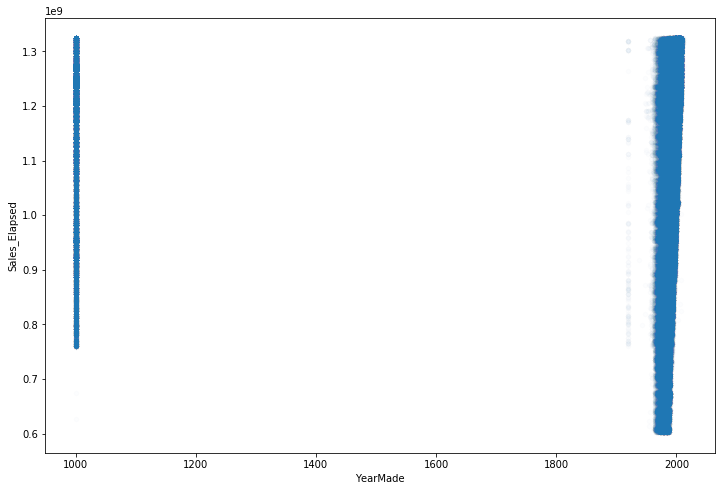

In [137]:
df_raw.plot('YearMade', 'Sales_Elapsed', 'scatter',figsize=(12,8), alpha=0.01)

In [138]:
x_all = get_sample(df_raw[df_raw.YearMade > 1930],  500)

C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\stats\smoothers.py:150: UserWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  warnings.warn("Confidence intervals are not yet implemented"


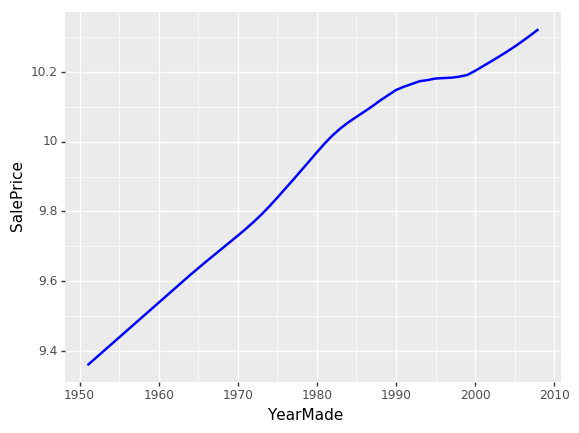

<ggplot: (-9223372036830189508)>

In [139]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(colour='blue', se=True)

In [146]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [147]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

In [165]:
x_feat = list(x.columns)

In [171]:
p = pdp.pdp_isolate(model=m, dataset=x, model_features=x_feat, feature='YearMade')

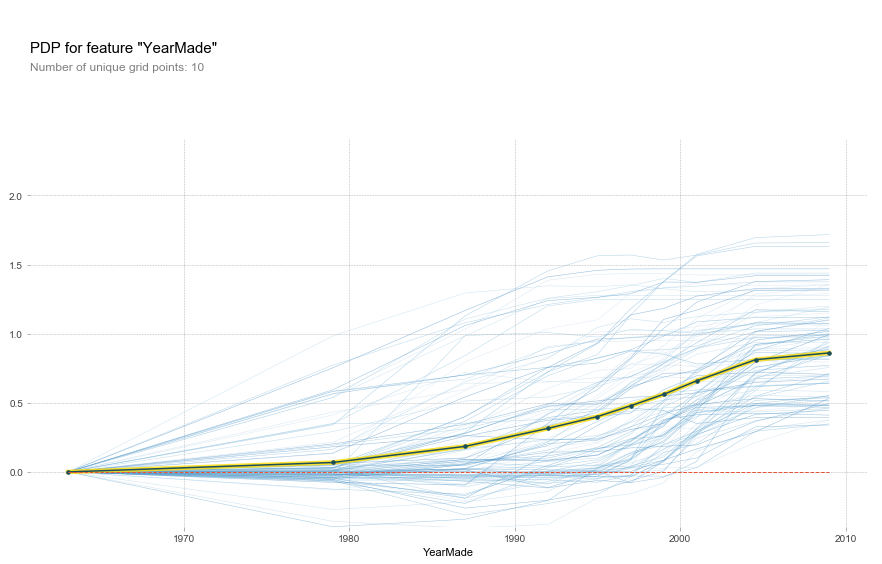

In [177]:
fig, axes = pdp.pdp_plot(p, 'YearMade', plot_lines=True, frac_to_plot=100)

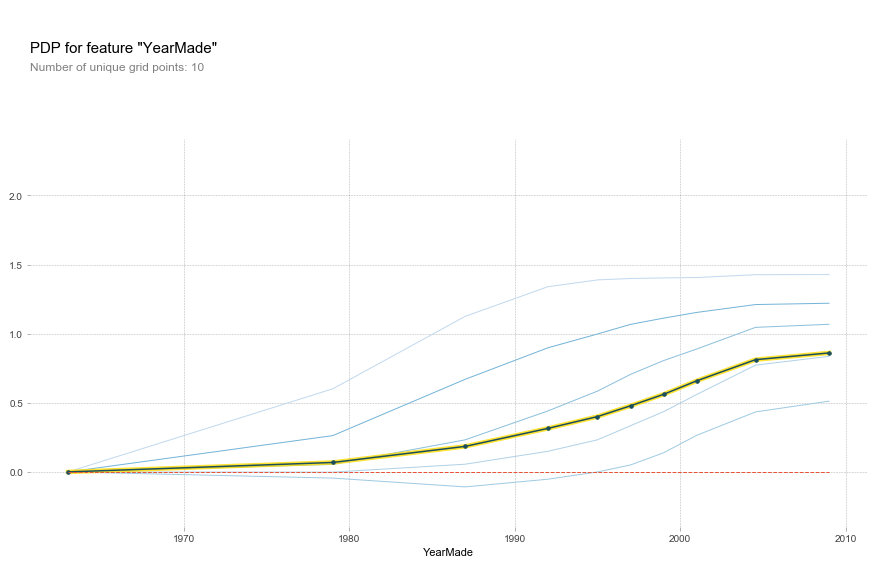

In [179]:
fig, axes = pdp.pdp_plot(p, 'YearMade', plot_lines=True, frac_to_plot=100, cluster=True, n_cluster_centers=5)

In [181]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, x_feat, feats)

ValueError: feature does not exist: saleElapsed